In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
import pandas as pd
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from scipy.stats import ttest_ind

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
df_measurement = pd.read_sql_table('measurement', engine)

In [7]:
df_station = pd.read_sql_table('station', engine)

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## *Precipitation Analysis*

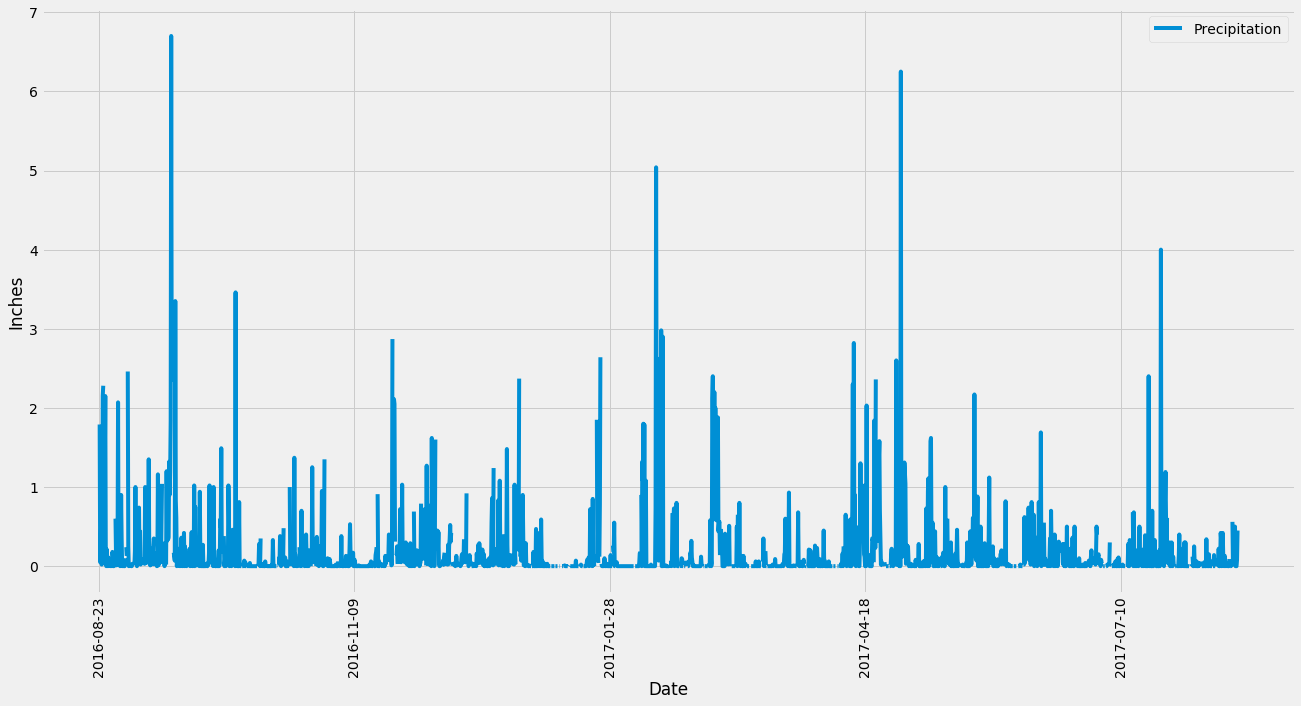

In [12]:
# # Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date)[-1]


# Perform a query to retrieve the data and precipitation scores

last_date = str(last_date).replace(')','').replace('(','').replace("'",'')
year, month, day = str(last_date).split('-')
year = int(year) - 1
month = month.replace(',','')
day = day.replace(',','')
year_ago = dt.date(year, int(month), int(day))
dates = []
precipitation = []
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago):
    dates.append(row[0])
    precipitation.append(row[1])
    
    
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame({'Date': dates, 'Precipitation': precipitation}).set_index('Date')


# Sort the dataframe by date

df.sort_values('Date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data

df.plot(figsize =(20,10), rot=90)
plt.ylabel('Inches')
plt.savefig('Images/precipitation.png')

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data

df.reset_index(inplace=True)

df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## *Station Analysis*

In [14]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.station)
print(f'There are {stations.count()} stations:\n')
for station in stations:
    print(station[0])

# Or
# station_data = session.query(Measurement.station).distinct()
# for station in station_data:
#     print(station)

There are 9 stations:

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [15]:
# Which are the most active stations? (i.e., which stations have the most rows)?
# List the stations and the counts in descending order.

station_data = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(station_data[0][0] + ' has the highest number of observations.')
print()
for station in station_data:
    print(station[0], station[1])

#Compare with this simple Pandas statement: df_measurement.groupby('station').id.count().sort_values(ascending=False)


USC00519281 has the highest number of observations.

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# min_temp = session.query(Measurement.station, func.min(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()[0]

print(f'Station data for {station_data[0][0]}:')
print()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_data[0][0]).all()[0][0]
print(f'\tLowest temperature: {min_temp:.2f}')
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_data[0][0]).all()[0][0]
print(f'\tHighest temperature: {max_temp:.2f}')
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_data[0][0]).all()[0][0]
print(f'\tAverage temperature: {avg_temp:.2f}')



Station data for USC00519281:

	Lowest temperature: 54.00
	Highest temperature: 85.00
	Average temperature: 71.66


In [17]:
# Choose the station with the highest number of temperature observations.

highest_obs = session.query(Measurement.station)\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()[0][0]

highest_obs

'USC00519281'

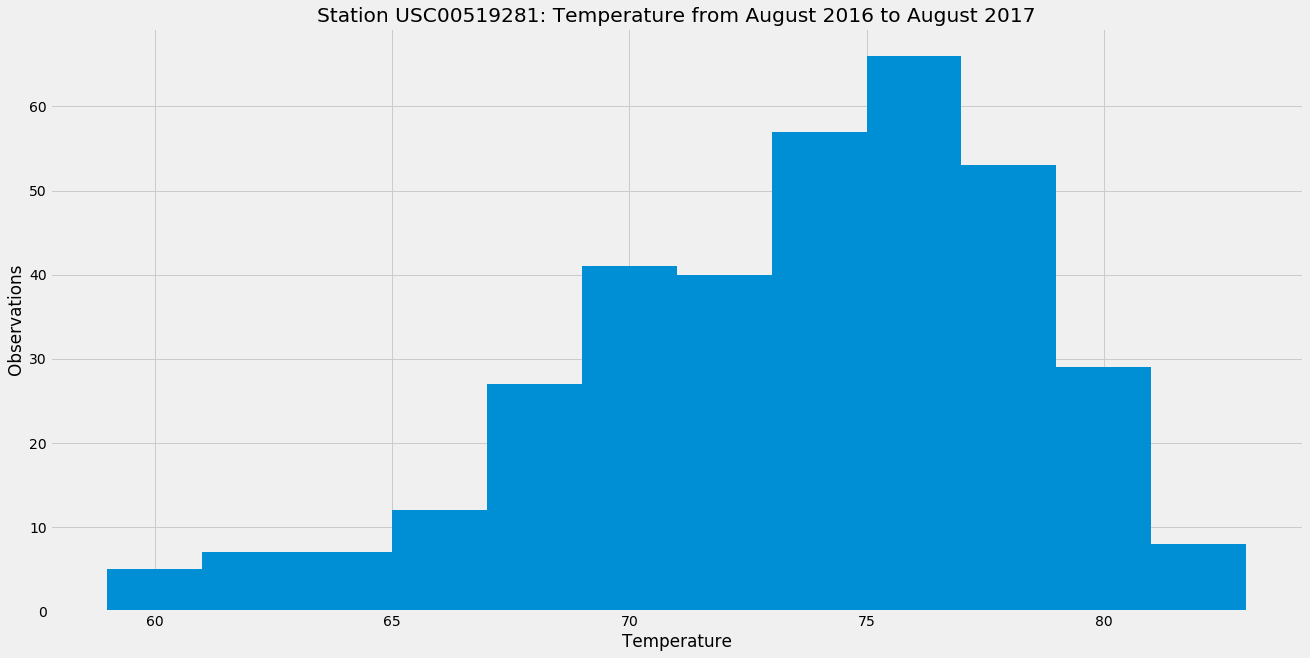

In [18]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date)[-1]


# Perform a query to retrieve the data and temperature scores

last_date = str(last_date).replace(')','').replace('(','').replace("'",'')
year, month, day = str(last_date).split('-')
year = int(year) - 1
month = month.replace(',','')
day = day.replace(',','')
year_ago = dt.date(year, int(month), int(day))
dates = []
temps = []
for row in session.query(Measurement.date, Measurement.tobs).filter((Measurement.date >= year_ago) & (Measurement.station == 'USC00519281')):
    dates.append(row[0])
    temps.append(row[1])
    
    
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame({'Date': dates, 'Temperature': temps}).set_index('Date')


# Sort the dataframe by date

df.sort_values('Date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data

df.hist(figsize =(20,10), bins=12)
plt.xlabel('Temperature')
plt.ylabel('Observations')
plt.title('Station USC00519281: Temperature from August 2016 to August 2017')
plt.savefig('Images/station-histogram.png')

# Bonus Challenge Assignment

## *Temperature Analysis I*

In [19]:
hm = pd.read_csv('Resources/hawaii_measurements.csv')
hs = pd.read_csv('Resources/hawaii_stations.csv')

In [20]:
jun = hm[hm.date.str.contains('-06-')]
dec = hm[hm.date.str.contains('-12-')]
print(f'June Average: {jun.tobs.mean():.2f}')
print(f'December Average: {dec.tobs.mean():.2f}')

June Average: 74.94
December Average: 71.04


In [21]:
# I used an independent samples t-test because the observations between months are, with the exception of station, independent of one another.
print('In Hawaii temperatures are higher in June (M=74.94) than in December (M=71.04), p < .05.')
ttest_ind(jun.tobs, dec.tobs)

In Hawaii temperatures are higher in June (M=74.94) than in December (M=71.04), p < .05.


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

## *Temperature Analysis II*

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tt = list(calc_temps('2017-07-01', '2017-07-14')[0])
trip_temps = pd.DataFrame({'Stat': ['Min', 'Average', 'Max'],'Temperatures': tt}).set_index('Stat')
trip_temps

,Temperatures
Stat,
Min,69.000000
Average,78.116279
Max,87.000000


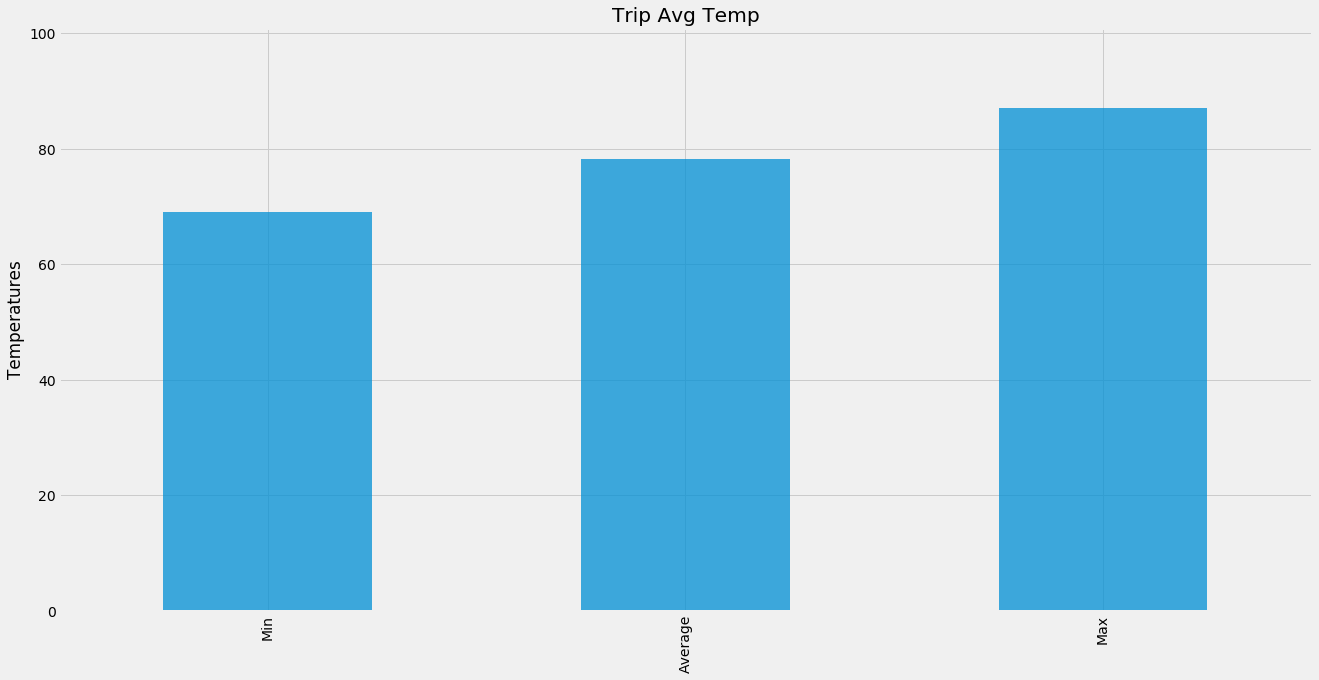

In [24]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps.plot.bar(alpha=0.75, figsize=(20,10), title='Trip Avg Temp',legend=None)

plt.ylabel('Temperatures')
plt.xlabel('')
plt.errorbar(x=3, y=78.11, yerr=18)
plt.savefig('Images/temperature.png')

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation.
sel = [Measurement.station, Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]
same_station = session.query(*sel).filter(Measurement.station == Station.station)

total_rainfall = same_station.group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

st, name, tprcp, lat, long, elev = [], [], [], [], [], []
for record in total_rainfall:
    Mstation, Sstation, Sname, Tprcp, Slat, Slong, Selev = record
    st.append(Mstation)
    name.append(Sname)
    tprcp.append(Tprcp)
    lat.append(Slat)
    long.append(Slong)
    elev.append(Selev)
    
trdf = pd.DataFrame({'Station': st, 'Name': name, 'Total Rainfall': tprcp, 'Latitude': lat, 'Longitude': long, 'Elevation': elev})
trdf

# Pandas code that does the same thing:
# alternative = pd.merge(df_measurement, df_station, on='station').groupby('station').prcp.sum().sort_values(ascending=False).reset_index()
# result = pd.merge(alternative, df_station, on='station').drop(columns='id')
# result

,Station,Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1068.09,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",588.64,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",382.62,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",295.68,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",131.62,21.27160,-157.81680,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",92.68,21.31520,-157.99920,0.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",70.87,21.49920,-158.01110,306.6
8,USC00517948,"PEARL CITY, HI US",43.44,21.39340,-157.97510,11.9


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

normals = []

# Set the start and end date of the trip

start = dt.date(2017, 7, 1)
end = dt.date(2017, 7, 14)


# Use the start and end date to create a range of dates

length = end - start

# Stip off the year and save a list of %m-%d strings
dates = []
for i in range(14):
    date = (start + dt.timedelta(days=i)).strftime('%m-%d')
    dates.append(date)

# Loop through the list of %m-%d strings and calculate the normals for each date

for date in dates:
    normals.append(daily_normals(date))
     
normals

[[(67.0, 74.77777777777777, 81.0)],
 [(68.0, 75.40384615384616, 82.0)],
 [(68.0, 75.32075471698113, 87.0)],
 [(70.0, 76.57142857142857, 81.0)],
 [(66.0, 75.0, 81.0)],
 [(69.0, 75.0, 81.0)],
 [(69.0, 74.91071428571429, 82.0)],
 [(69.0, 76.08333333333333, 83.0)],
 [(68.0, 76.19298245614036, 83.0)],
 [(68.0, 75.62068965517241, 82.0)],
 [(70.0, 75.78947368421052, 81.0)],
 [(67.0, 75.96491228070175, 82.0)],
 [(69.0, 76.1896551724138, 81.0)],
 [(61.0, 76.2280701754386, 82.0)]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin, tavg, tmax = [], [], []

for normal in normals:
    for stat in normal:
        tmin.append(stat[0])
        tavg.append(stat[1])
        tmax.append(stat[2])


trip_df = pd.DataFrame({'Date': dates,'Minimum': tmin, 'Average': tavg, 'Maximum': tmax}).set_index('Date')
trip_df

,Minimum,Average,Maximum
Date,,,
07-01,67.0,74.777778,81.0
07-02,68.0,75.403846,82.0
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0


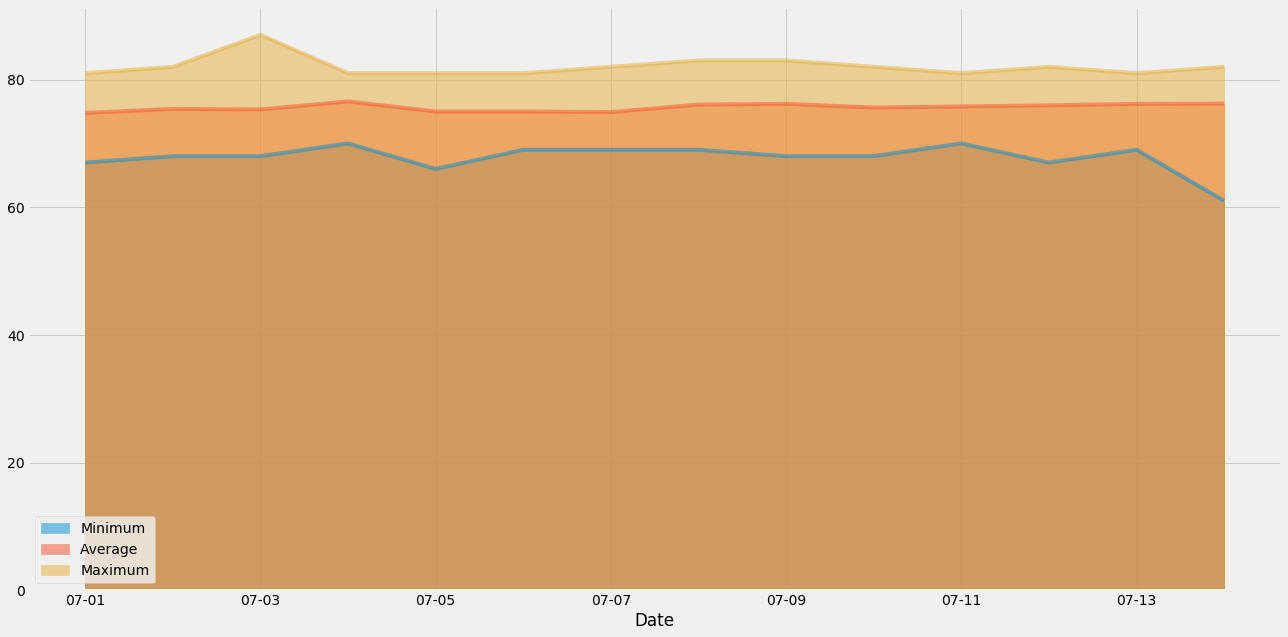

In [29]:
# Plot the daily normals as an area plot with `stacked=False`

trip_df.plot.area(stacked=False, figsize=(20,10))
plt.ylabel=('Temperature')
plt.savefig('Images/daily-normals.png')